In [ ]:
hyperparameters = {
    "learning_rate": 0.0001,
    "batch_size": 256,
    "embed_dim": 256,
    "num_heads": 4,
    "num_layers": 2,
    "dropout": 0.1,
    "ff_dim": 1024,
    "epochs": 50
}

info = {
    "dataset_size": "500K",
    "precision": "FP16",
    "is_pre_training": True,
    "model_name": "model_First_Run_epoch_40"
}

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd

data_path = f"/content/drive/MyDrive/{info['dataset_size']}.csv"

data = pd.read_csv(data_path)
data.shape

(500000, 10)

In [6]:
x = data['sequence']
y = data['label']

In [7]:
def get_codon(seq, k=3):
    return [seq[i:i+k] for i in range(len(seq) - k + 1)]

vocab = {'<PAD>': 0, '<UNK>': 1}

for seq in data['sequence']:
    for codons in get_codon(seq.lower()):
        if codons not in vocab:
            vocab[codons] = len(vocab)
        else:
            continue

def get_tensor(text):
    return [vocab.get(codons.lower(), vocab['<UNK>']) for codons in get_codon(text)]

In [8]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split

class CustomDataset(Dataset):
  def __init__(self, x, y):
    self.x_frame = x
    self.y_frame = y

  def __len__(self):
    return len(self.x_frame)

  def __getitem__(self, index):
    x = torch.tensor(get_tensor(self.x_frame[index]), dtype=torch.long)
    y = torch.tensor(self.y_frame[index], dtype=torch.long)
    return x, y

In [9]:
dataset = CustomDataset(x, y)

In [10]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'])

In [12]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len).unsqueeze(1)

        div_term = torch.exp((torch.arange(0, embed_dim, 2)) * (-math.log(10000.0) / embed_dim))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return x

class Transformer(nn.Module):
    def __init__(self, embed_dim=512, num_heads=8, num_layers=6, ff_dim=2048, dropout=0.1, vocab_size=10000, max_len=5000):
        super(Transformer, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.position_encoding = PositionalEncoding(embed_dim=embed_dim, max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=num_layers
        )

        self.y_labels_out = nn.Linear(embed_dim, 5)

    def forward(self, x):
        x = self.embeddings(x)
        x = self.position_encoding(x)

        x = self.encoder(x)
        x = x.mean(dim=1)

        y_label_out = self.y_labels_out(x)
        return y_label_out

In [13]:
model = Transformer(
    embed_dim=hyperparameters['embed_dim'],
    num_heads=hyperparameters['num_heads'],
    num_layers=hyperparameters['num_layers'],
    ff_dim=hyperparameters['ff_dim'],
    dropout=hyperparameters['dropout'],
    vocab_size=len(vocab),
    max_len=200
)

In [14]:
checkpoint = torch.load(f"/content/drive/MyDrive/{info['model_name']}.pth")

In [15]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Transformer(
  (embeddings): Embedding(66, 256)
  (position_encoding): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (y_labels_out): Linear(in_features=256, out_features=5, bias=True)
)

In [17]:
device

device(type='cuda')

In [18]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {num_params}")

Total trainable parameters: 1597701


In [19]:
from transformers import get_linear_schedule_with_warmup

ce = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters['learning_rate'], weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()

if info['is_pre_training']:
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  print("Optimizer loaded")

num_training_steps = len(train_loader) * hyperparameters['epochs']
num_warmup_steps = 500

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

Optimizer loaded


/tmp/ipython-input-3077670767.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [20]:
def train32(model, loader, ce, optimizer):
    model.train()

    running_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        optimizer.zero_grad()

        x = x.to(device)
        y = y.to(device)

        output = model(x)
        loss = ce(output, y)

        prediction = torch.argmax(output, dim=1)
        correct += (prediction == y).sum().item()
        total += len(x)

        loss.backward()

        optimizer.step()

        running_loss += loss.item() * len(x)

    accuracy = correct / total

    return (
        running_loss / len(loader.dataset),
        accuracy
    )

def train16(model, loader, ce, optimizer, scaler, scheduler):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)

        with torch.cuda.amp.autocast(dtype=torch.float16):
            output = model(x)
            loss = ce(output, y)

        prediction = torch.argmax(output, dim=1)
        correct += (prediction == y).sum().item()
        total += len(x)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        scheduler.step()

        running_loss += loss.item() * len(x)

    accuracy = correct / total
    return (
        running_loss / len(loader.dataset),
        accuracy
    )

In [21]:
def validation(model, loader, ce):
    model.eval()

    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            if info['precision'] == 'FP16':
              with torch.cuda.amp.autocast(dtype=torch.float16):
                  output = model(x)
                  loss = ce(output, y)
            else:
              output = model(x)
              loss = ce(output, y)

            running_loss += loss.item() * len(x)

            prediction = torch.argmax(output, dim=1)
            correct += (prediction == y).sum().item()

            total += len(x)

    accuracy = correct / total

    return (
        running_loss / len(loader.dataset),
        accuracy
    )

In [22]:
import os

patience = 10
best_val_loss = float('inf')
counter = 0
early_stop = False

save_dir = f"/content/drive/MyDrive/{info['project_name']}"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(84, 150):
    if info['precision'] == 'FP16':
      train_loss, train_acc = train16(
            model,
            train_loader,
            ce,
            optimizer,
            scaler,
            scheduler
        )
    else:
      train_loss, train_acc = train32(
          model,
          train_loader,
          ce,
          optimizer
      )

    val_loss, val_acc = validation(
        model,
        test_loader,
        ce
    )

    print(f"Epoch ({epoch+1}/150): Train Loss = {train_loss:.4f}, Valitation Loss = {val_loss:.4f}, Train_acc = {train_acc:.4f}, Val_acc = {val_acc:.4f}")

    # wandb.log({
    #     "epoch": epoch,
    #     "train_loss": train_loss,
    #     "val_loss": val_loss,
    #     "train_acc": train_acc,
    #     "val_acc": val_acc
    # })

    if (epoch+1) % 10 == 0:
      checkpoint_path = f"{save_dir}/model_{info['name']}_epoch_{epoch+1}.pth"
      torch.save({
          'epoch': epoch+1,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'train_losses': train_loss,
          'val_losses': val_loss
      }, checkpoint_path)
      print(f"Model saved at {checkpoint_path}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        continue
    else:
        counter += 1
        print(f"No improvement in val loss Counter = {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered!")
            early_stop = True
            break

/tmp/ipython-input-2163399810.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16):
/tmp/ipython-input-260272857.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16):


Epoch (85/150): Train Loss = 0.8766, Valitation Loss = 0.8680, Train_acc = 0.6569, Val_acc = 0.6615
Epoch (86/150): Train Loss = 0.8734, Valitation Loss = 0.8666, Train_acc = 0.6589, Val_acc = 0.6614
Epoch (87/150): Train Loss = 0.8660, Valitation Loss = 0.8614, Train_acc = 0.6636, Val_acc = 0.6659
Epoch (88/150): Train Loss = 0.8588, Valitation Loss = 0.8489, Train_acc = 0.6688, Val_acc = 0.6748
Epoch (89/150): Train Loss = 0.8499, Valitation Loss = 0.8473, Train_acc = 0.6752, Val_acc = 0.6770
Epoch (90/150): Train Loss = 0.8415, Valitation Loss = 0.8351, Train_acc = 0.6810, Val_acc = 0.6837
Model saved at /content/drive/MyDrive/dna-test-50K/model_forth-run_epoch_90.pth
Epoch (91/150): Train Loss = 0.8339, Valitation Loss = 0.8377, Train_acc = 0.6859, Val_acc = 0.6843
No improvement in val loss Counter = 1/10
Epoch (92/150): Train Loss = 0.8269, Valitation Loss = 0.8231, Train_acc = 0.6899, Val_acc = 0.6926
Epoch (93/150): Train Loss = 0.8206, Valitation Loss = 0.8289, Train_acc = 0.6

In [ ]:
wandb.finish()

In [23]:
from sklearn.metrics import classification_report

def get_predictions_and_labels(model, loader):
    model.eval()
    all_y_true = []

    all_y_pred = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            output = model(x)

            _, prediction = torch.max(output, 1)

            all_y_true.extend(y.cpu().numpy())

            all_y_pred.extend(prediction.cpu().numpy())

    return (all_y_true, all_y_pred)

y_true, y_pred = get_predictions_and_labels(model, test_loader)

print("Classification Report for Label:")
print(classification_report(y_true, y_pred))
print("-"*20)

Classification Report for Label:
              precision    recall  f1-score   support

           0       0.45      0.05      0.10      5931
           1       0.69      0.67      0.68     31732
           2       0.75      0.88      0.81     57783
           3       0.53      0.19      0.28      2134
           4       0.28      0.01      0.02      2420

    accuracy                           0.73    100000
   macro avg       0.54      0.36      0.38    100000
weighted avg       0.70      0.73      0.70    100000

--------------------


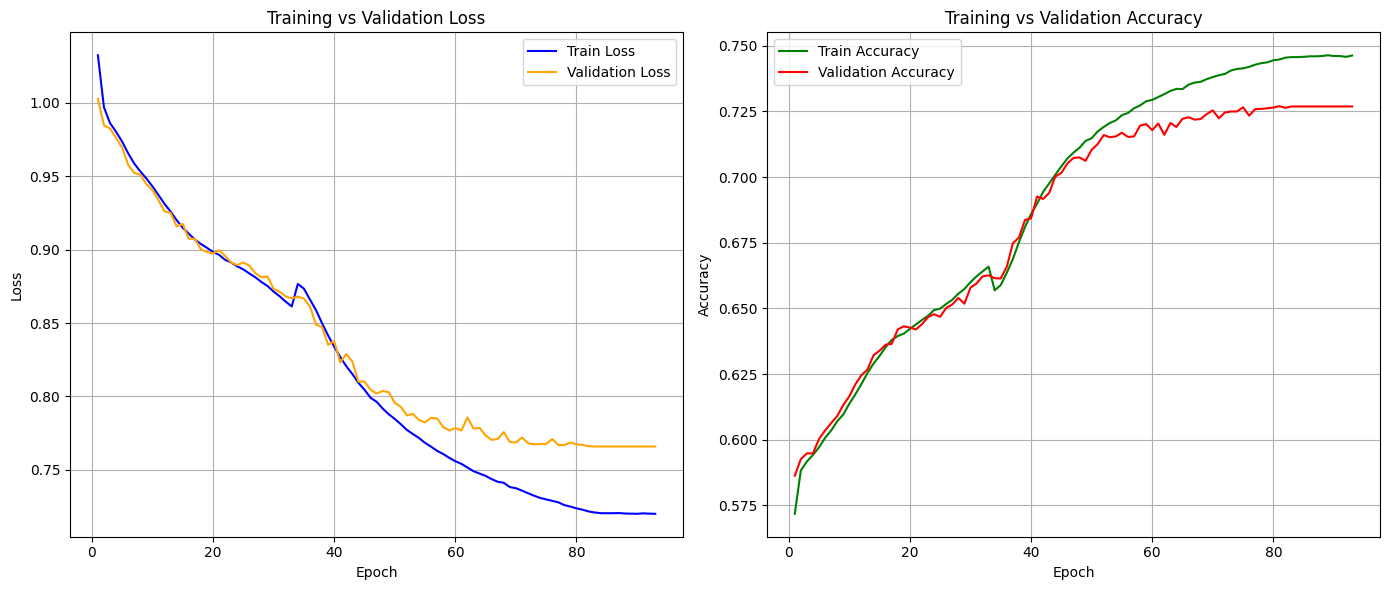

In [24]:
import matplotlib.pyplot as plt

# Existing data (33 epochs)
train_loss = [1.0323, 0.9969, 0.9861, 0.9802, 0.9735, 0.9655, 0.9586, 0.9532, 0.9484, 0.9431,
              0.9371, 0.9311, 0.9259, 0.9200, 0.9149, 0.9108, 0.9068, 0.9038, 0.9012, 0.8984,
              0.8964, 0.8930, 0.8912, 0.8886, 0.8865, 0.8837, 0.8811, 0.8779, 0.8752, 0.8714,
              0.8682, 0.8645, 0.8613]

val_loss = [1.0027, 0.9846, 0.9824, 0.9761, 0.9694, 0.9577, 0.9522, 0.9510, 0.9445, 0.9406,
            0.9336, 0.9260, 0.9250, 0.9158, 0.9175, 0.9073, 0.9073, 0.9002, 0.8983, 0.8974,
            0.8995, 0.8957, 0.8911, 0.8895, 0.8912, 0.8890, 0.8839, 0.8811, 0.8817, 0.8733,
            0.8712, 0.8681, 0.8668]

train_acc = [0.5718, 0.5883, 0.5917, 0.5942, 0.5971, 0.6007, 0.6035, 0.6070, 0.6096, 0.6137,
             0.6173, 0.6212, 0.6254, 0.6290, 0.6319, 0.6353, 0.6380, 0.6395, 0.6404, 0.6422,
             0.6439, 0.6456, 0.6472, 0.6494, 0.6499, 0.6517, 0.6533, 0.6556, 0.6574, 0.6600,
             0.6622, 0.6641, 0.6659]

val_acc = [0.5863, 0.5926, 0.5948, 0.5948, 0.6003, 0.6035, 0.6063, 0.6090, 0.6132, 0.6165,
           0.6211, 0.6246, 0.6267, 0.6322, 0.6339, 0.6362, 0.6365, 0.6420, 0.6432, 0.6427,
           0.6420, 0.6440, 0.6467, 0.6478, 0.6468, 0.6502, 0.6515, 0.6540, 0.6518, 0.6579,
           0.6595, 0.6622, 0.6626]

# Additional data from epochs 85 to 144 (total 60 epochs)
additional_train_loss = [
    0.8766, 0.8734, 0.8660, 0.8588, 0.8499, 0.8415, 0.8339, 0.8269, 0.8206, 0.8153,
    0.8093, 0.8046, 0.7991, 0.7964, 0.7918, 0.7879, 0.7847, 0.7811, 0.7772, 0.7744,
    0.7717, 0.7684, 0.7658, 0.7629, 0.7608, 0.7582, 0.7559, 0.7541, 0.7516, 0.7491,
    0.7475, 0.7459, 0.7437, 0.7419, 0.7412, 0.7383, 0.7375, 0.7359, 0.7341, 0.7324,
    0.7309, 0.7299, 0.7289, 0.7279, 0.7260, 0.7250, 0.7238, 0.7229, 0.7217, 0.7210,
    0.7205, 0.7205, 0.7205, 0.7206, 0.7203, 0.7202, 0.7201, 0.7204, 0.7202, 0.7201
]

additional_val_loss = [
    0.8680, 0.8666, 0.8614, 0.8489, 0.8473, 0.8351, 0.8377, 0.8231, 0.8289, 0.8238,
    0.8101, 0.8102, 0.8046, 0.8020, 0.8037, 0.8029, 0.7957, 0.7930, 0.7871, 0.7881,
    0.7839, 0.7823, 0.7855, 0.7849, 0.7792, 0.7768, 0.7785, 0.7768, 0.7857, 0.7781,
    0.7786, 0.7734, 0.7704, 0.7711, 0.7757, 0.7690, 0.7686, 0.7721, 0.7682, 0.7674,
    0.7676, 0.7677, 0.7710, 0.7669, 0.7669, 0.7687, 0.7673, 0.7670, 0.7661, 0.7659,
    0.7659, 0.7659, 0.7659, 0.7659, 0.7659, 0.7659, 0.7659, 0.7659, 0.7659, 0.7659
]

additional_train_acc = [
    0.6569, 0.6589, 0.6636, 0.6688, 0.6752, 0.6810, 0.6859, 0.6899, 0.6944, 0.6976,
    0.7009, 0.7041, 0.7071, 0.7093, 0.7112, 0.7138, 0.7148, 0.7174, 0.7191, 0.7206,
    0.7216, 0.7236, 0.7244, 0.7262, 0.7273, 0.7289, 0.7294, 0.7305, 0.7316, 0.7328,
    0.7336, 0.7335, 0.7352, 0.7360, 0.7363, 0.7373, 0.7381, 0.7388, 0.7393, 0.7406,
    0.7412, 0.7414, 0.7420, 0.7428, 0.7434, 0.7437, 0.7445, 0.7448, 0.7455, 0.7457,
    0.7457, 0.7458, 0.7460, 0.7460, 0.7461, 0.7464, 0.7461, 0.7461, 0.7458, 0.7463
]

additional_val_acc = [
    0.6615, 0.6614, 0.6659, 0.6748, 0.6770, 0.6837, 0.6843, 0.6926, 0.6917, 0.6940,
    0.7002, 0.7016, 0.7052, 0.7073, 0.7075, 0.7062, 0.7104, 0.7126, 0.7160, 0.7152,
    0.7155, 0.7169, 0.7153, 0.7155, 0.7196, 0.7202, 0.7179, 0.7204, 0.7161, 0.7206,
    0.7191, 0.7222, 0.7228, 0.7219, 0.7221, 0.7240, 0.7254, 0.7224, 0.7246, 0.7250,
    0.7250, 0.7266, 0.7234, 0.7259, 0.7260, 0.7262, 0.7265, 0.7270, 0.7264, 0.7269,
    0.7269, 0.7269, 0.7269, 0.7269, 0.7269, 0.7269, 0.7269, 0.7269, 0.7269, 0.7269
]

# Append additional values
train_loss += additional_train_loss
val_loss += additional_val_loss
train_acc += additional_train_acc
val_acc += additional_val_acc

# Epochs
epochs = list(range(1, len(train_loss) + 1))  # total epochs = 33 + 60 = 93

# Plotting
plt.figure(figsize=(14, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy', color='green')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='red')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()